In [1]:
import math
import os
import pandas as pd

import numpy as np

from matplotlib.colors import LogNorm
import time 
import tqdm
import h5py
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.figure import Figure
import datetime
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from cutax.cutlist import CutList
from cutax import cut_efficiency
from cutax.cut_efficiency import CutAcceptance
#from cutax.cuts.s1_hitperpmt import *
from matplotlib.colors import LogNorm
import straxen
import cutax

# import plotly.express as px
from scipy.stats import kde
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
import xgboost 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib

/tmp/jobs/29415759/ipykernel_201/2707031857.py:30: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
%run -i 'YBe_tool.py'
%run -i 'stuff_to_load.py'


In [3]:
%matplotlib inline

In [4]:
params = {
    'font.family': 'serif',
    'font.size' : 24, 'axes.titlesize' : 42, 'axes.labelsize' : 32, 'axes.linewidth' : 2,
    # ticks
    'xtick.labelsize' : 24, 'ytick.labelsize' : 24, 'xtick.major.size' : 16, 'xtick.minor.size' : 8,
    'ytick.major.size' : 16, 'ytick.minor.size' : 8, 'xtick.major.width' : 2, 'xtick.minor.width' : 2,
    'ytick.major.width' : 2, 'ytick.minor.width' : 2, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 8, 'lines.markeredgewidth' : 2, 'errorbar.capsize' : 5, 'lines.linewidth' : 2,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 12,
    'axes.labelsize': 24, 'axes.titlesize':24, 'xtick.labelsize':18, 'ytick.labelsize':18,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':12,
    # ticks
    'xtick.major.pad': 6,   'xtick.minor.pad': 6,   
    'ytick.major.pad': 3.5, 'ytick.minor.pad': 3.5,
}
plt.rcParams.update(params)

In [5]:
def cut_S1OneHitPerPMT(events):
        mask = events['s1_n_channels'] == events['s1_n_hits']
        mask |= ~(events['s1_n_hits']<=3)
        events['cut_s1_one_hit_per_pmt'] = mask
        return events

def cut_s1_n_nits(events):
        mask = events['s1_n_hits'] <= 3
        events['cut_cevns_search_s1_n_hits'] = mask
        return events
    
def cut_YBe_FV(df):
    theta_min = -1 * math.pi / 12
    theta_max = 0.4 * math.pi
    mask = df['r'] > 33
    mask &= df['r'] < 63
    mask &= df['y'] > math.tan(theta_min) * df['x']
    mask &= df['y'] < math.tan(theta_max) * df['x']
    mask &= df['z'] > -138.6515
    mask &= df['z'] < -20
    
    df['cut_fv_ybe'] = mask
    return df

def cut_s1_aft_ybe(df):
    mask = df['s1_area_fraction_top'] <=0.8
    mask |= df['s1_tight_coincidence'] >=3
    df['cut_s1_aft_ybe'] = mask
    
    return df

In [6]:
import pickle

file_path = "/project2/lgrandi/zxu/process_ybe/ybe_data_no_cuts_strax_1.4.2_straxen_2.0.6.pkl"
with open(file_path, "rb") as file:
    
    loaded_object = pickle.load(file)

In [7]:
def filter_basic(df):
    mask = (
                df['cut_fiducial_volume_ybe']#(df['cut_fv_ybe'])
                &(df['cut_interaction_exists'])
                &(df['cut_far_wires'])#(df['wire_cut'])
                        # &(df['cut_cs2_area_fraction_top'])
                
        )
    df_afc = df.loc[mask]
     
    return df_afc

In [8]:
def make_box(df,box,color):
    x1,x2,y1,y2=box
    sel=df[(df['s1_area'] >= x1) & (df['s1_area'] <= x2) & (df['s2_area'] >= y1) & (df['s2_area'] <= y2)]
    count=sel.shape[0]
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, label=f'{count} events'))
    return sel

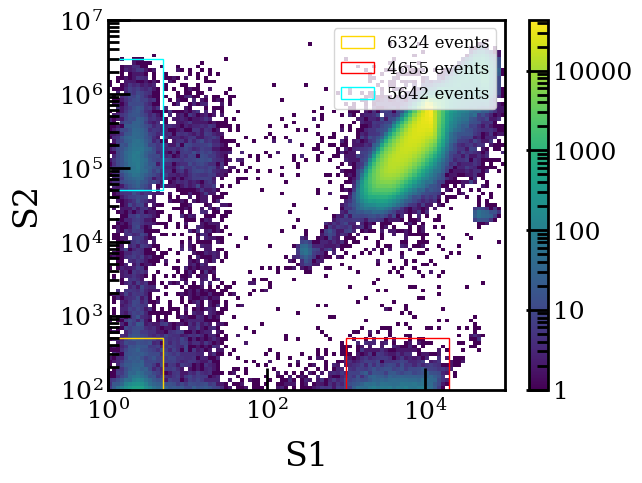

In [9]:
df=filter_basic(loaded_object)
xbins=np.logspace(0,5,100)
ybins=np.logspace(2,7,100)
plt.hist2d(df.s1_area, df.s2_area, bins=[xbins, ybins],norm=matplotlib.colors.LogNorm())
colorbar = plt.colorbar(format=matplotlib.ticker.LogFormatter())
make_box(df,[1,5,100,500],'gold')
make_box(df,[1e3,2e4,100,500],'red')
make_box(df,[1,5,5e4,3e6],'cyan')
plt.xlabel('S1')
plt.ylabel('S2')
plt.yscale('log')
plt.xscale('log')
plt.legend()

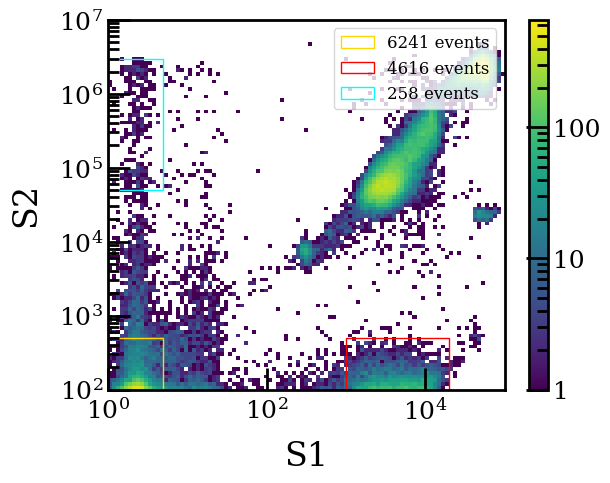

In [10]:
df=filter_basic(loaded_object)
df=df[df.cut_cs2_area_fraction_top]
xbins=np.logspace(0,5,100)
ybins=np.logspace(2,7,100)
plt.hist2d(df.s1_area, df.s2_area, bins=[xbins, ybins],norm=matplotlib.colors.LogNorm())
colorbar = plt.colorbar(format=matplotlib.ticker.LogFormatter())
make_box(df,[1,5,100,500],'gold')
make_box(df,[1e3,2e4,100,500],'red')
make_box(df,[1,5,5e4,3e6],'cyan')
plt.xlabel('S1')
plt.ylabel('S2')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [11]:
def filter_no_ROI(df):
    mask = (df['cut_fiducial_volume_ybe']#(df['cut_fv_ybe'])
                &(df['cut_interaction_exists'])
                &(df['cut_far_wires'])#(df['wire_cut'])
                # &(df['s1_tight_coincidence'] <= 3)
                
                # &(df['cut_s1_one_hit_per_pmt'])
                # &(df['cut_cevns_search_s1_n_hits'])
                #&(df['cut_s1_aft_ybe'])
                
                
                &(df['cut_cs2_area_fraction_top'])
                &(df['cut_s2_recon_pos_diff'])
                &(df['cut_s2_naive_bayes'])
                #&(df['cut_bdt_ac'])
                &(df['cut_time_veto'])
                &(df['cut_time_shadow'])
                &(df['cut_position_shadow'])
                &(df['cut_ambience'])
        )
    df_afc = df.loc[mask]
     
    return df_afc

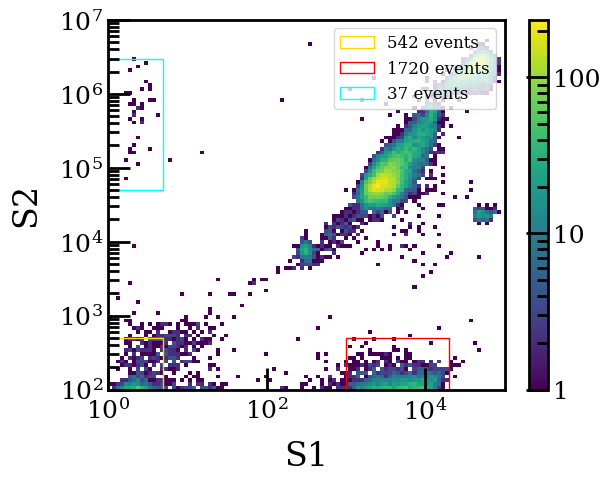

In [14]:
df=filter_no_ROI(loaded_object)
xbins=np.logspace(0,5,100)
ybins=np.logspace(2,7,100)
plt.hist2d(df.s1_area, df.s2_area, bins=[xbins, ybins],norm=matplotlib.colors.LogNorm())
colorbar = plt.colorbar(format=matplotlib.ticker.LogFormatter())
make_box(df,[1,5,100,500],'gold')
overlap=make_box(df,[1e3,2e4,100,500],'red')
make_box(df,[1,5,5e4,3e6],'cyan')
plt.xlabel('S1')
plt.ylabel('S2')
plt.yscale('log')
plt.xscale('log')
plt.legend()

^ Awesome table ^^^^^
^ cut ^ n_pre ^ n_after ^ fraction ^ cumulative_fraction ^
| cut_fiducial_volume_ybe | 31902 | 9687 | 0.30365 | 0.30365 |
| cut_interaction_exists | 9687 | 9687 | 1.0 | 0.30365 |
| cut_far_wires | 9687 | 6324 | 0.65283 | 0.19823 |
| cut_cs2_area_fraction_top | 6324 | 6241 | 0.98688 | 0.19563 |
| cut_s2_recon_pos_diff | 6241 | 6198 | 0.99311 | 0.19428 |
| cut_s2_naive_bayes | 6198 | 6140 | 0.99064 | 0.19246 |
| cut_time_veto | 6140 | 6134 | 0.99902 | 0.19228 |
| cut_time_shadow | 6134 | 3790 | 0.61787 | 0.1188 |
| cut_position_shadow | 3790 | 667 | 0.17599 | 0.02091 |
| cut_ambience | 667 | 542 | 0.81259 | 0.01699 |



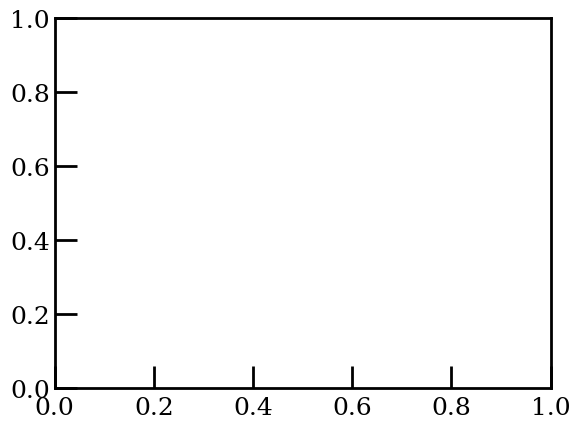

In [13]:
df=make_box(loaded_object,[1,5,100,500],'gold')
this=['cut_fiducial_volume_ybe','cut_interaction_exists','cut_far_wires','cut_cs2_area_fraction_top','cut_s2_recon_pos_diff','cut_s2_naive_bayes','cut_time_veto','cut_time_shadow','cut_position_shadow','cut_ambience']
print(cut_acceptance_n_minus_one(df,this))

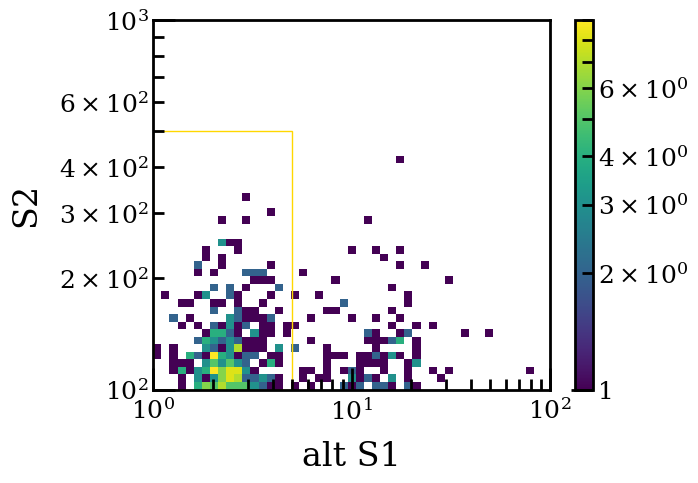

In [40]:
xbins=np.logspace(0,2,50)
ybins=np.logspace(2,3,50)
plt.hist2d(overlap.alt_s1_area, overlap.s2_area, bins=[xbins, ybins],norm=matplotlib.colors.LogNorm())
colorbar = plt.colorbar(format=matplotlib.ticker.LogFormatter())
make_box(df,[1,5,100,500],'gold')

plt.xlabel('alt S1')
plt.ylabel('S2')
plt.yscale('log')
plt.xscale('log')
# plt.legend()

In [34]:
nan_count=overlap.alt_s1_area.isna().sum()
nan_count

1253

In [35]:
len(overlap)-nan_count

467

In [36]:
len(overlap[(overlap.alt_s1_area<5)&(overlap.s2_area<500)])

342